In [1]:
##Estimación de indicadores de gobierno. Satisfacción
#Se borra todo lo que se encuentra en el entorno

rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, srvyr,showtext)
remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)

font_add_google("Poppins", "pop")
showtext_auto()

Cargando paquete requerido: pacman

Using GitHub PAT from the git credential store.




rlang    (1.1.4 -> 1.1.6) [CRAN]
glue     (1.7.0 -> 1.8.0) [CRAN]
cli      (3.6.3 -> 3.6.5) [CRAN]
magrittr (2.0.3 -> 2.0.4) [CRAN]
tibble   (3.2.1 -> 3.3.0) [CRAN]
ggplot2  (3.5.2 -> 4.0.0) [CRAN]


Installing 6 packages: rlang, glue, cli, magrittr, tibble, ggplot2

Warning message:
"packages 'tibble', 'ggplot2' are in use and will not be installed"
Installing packages into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\rlang\libs\x64\rlang.dll: Permission denied"
Warning message:
"restored 'rlang'"


package 'glue' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'glue'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\glue\libs\x64\glue.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\glue\libs\x64\glue.dll: Permission denied"
Warning message:
"restored 'glue'"


package 'cli' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'cli'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\cli\libs\x64\cli.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\cli\libs\x64\cli.dll: Permission denied"
Warning message:
"restored 'cli'"


package 'magrittr' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'magrittr'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\magrittr\libs\x64\magrittr.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\magrittr\libs\x64\magrittr.dll: Permission denied"
Warning message:
"restored 'magrittr'"



The downloaded binary packages are in
	C:\Users\claud\AppData\Local\Temp\RtmpkLuxJk\downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file 'C:\Users\claud\AppData\Local\Temp\RtmpkLuxJk\remotes98836617905\cpyp-ipdp-funcionespgd-6fd64b9/DESCRIPTION' ... OK
* preparing 'funcionespgd':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted 'LazyData' from DESCRIPTION
* building 'funcionespgd_0.1.0.tar.gz'



Installing package into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



In [2]:
dir.create("data", showWarnings = FALSE)

In [3]:
url_encig_basica<-"https://www.inegi.org.mx/contenidos/programas/encig/"
segunda_parte<-"microdatos/encig"
years_encig<-c("2017","2019","2021", "2023")

In [11]:
# Descargar los archivos, descomprimirlos y renombrarlos
options(timeout=10000)
for (i in 1:length(years_encig)) {
  # Ajustar el sufijo de la URL y archivo según el año
  if (years_encig[i] %in% c("2017", "2019")) {
    fin <- "_base_datos_dbf.zip"
  } else {
    fin <- "_base_datos_csv.zip"
  }

  # Construir la URL y el nombre del archivo destino
  url <- paste0(url_encig_basica, years_encig[i], "/", segunda_parte, str_sub(years_encig[i], 3, 4), fin)
  print(url)
  destfile <- paste0("data/encig", str_sub(years_encig[i], 3, 4), fin)

  # Descargar el archivo
  download.file(url, destfile = destfile)

  # Descomprimir el archivo
  unzip(destfile, exdir = "data/encig")
}

[1] "https://www.inegi.org.mx/contenidos/programas/encig/2017/microdatos/encig17_base_datos_dbf.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2019/microdatos/encig19_base_datos_dbf.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2021/microdatos/encig21_base_datos_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2023/microdatos/encig23_base_datos_csv.zip"


In [42]:
process_files <- function(years, variable) {

  # --- MAPEO servicio -> variable por año ---
  serv_map <- list(
    #"Salud"    = c(`2017`="p5_6b",  `2019`="p5_6b",  `2021`="p5_6b",  `2023`="p5_6b"),
    "Microbús" = c(`2017`="p5_8b",  `2019`="p5_8b",  `2021`="p5_8b",  `2023`="p5_9b"),
    "Metrobús" = c(`2017`="p5_9b",  `2019`="p5_9b",  `2021`="p5_9b",  `2023`="p5_10b"),
    "Cablebús" = c(`2017`=NA,      `2019`=NA,      `2021`=NA,       `2023`="p5_11b"),
    "Metro" = c(`2017`="p5_11b",  `2019`="p5_11b",  `2021`="p5_10b",  `2023`="p5_12b"),
    "Agua" = c(`2017`="p4_1b",  `2019`="p4_1b",  `2021`="p4_1b",  `2023`="p4_1b"),
    "Alcantarillado" = c(`2017`="p4_2b",  `2019`="p4_2b",  `2021`="p4_2b",  `2023`="p4_2b"),
    "Alumbrado público" = c(`2017`="p4_3b",  `2019`="p4_3b",  `2021`="p4_3b",  `2023`="p4_3b"),
    "Parques y jardines" = c(`2017`="p4_4b",  `2019`="p4_4b",  `2021`="p4_4b",  `2023`="p4_4b"),
    "Recolección de basura" = c(`2017`="p4_5b",  `2019`="p4_5b",  `2021`="p4_5b",  `2023`="p4_5b"),
    "Policía" = c(`2017`="p4_6b", `2019`="p4_6b",  `2021`="p4_6b",  `2023`="p4_6b"),
    "Calles y avenidas" = c(`2017`="p4_7b",  `2019`="p4_7b",  `2021`="p4_7b",  `2023`="p4_7b")
  )

  # -------- función anidada --------
  estima_indicador <- function(path, variable) {
    year <- substr(path, 11, 14)

    # --- Lectura y preparación ---
    if (year %in% c("2017", "2019")) {
      datos <- foreign::read.dbf(path) %>%
        janitor::clean_names() %>%
        dplyr::mutate(
          p11_1_6 = if ("p11_1_6" %in% names(.)) as.numeric(p11_1_6) else as.numeric(p3_2),
          fac_p18 = as.numeric(fac_p18),
          upm     = as.numeric(upm),
          est_dis = as.numeric(est_dis)
        ) %>%
        dplyr::filter(ent == "09")
    } else if (year %in% c("2021", "2023")) {
      datos <- readr::read_csv(path, show_col_types = FALSE) %>%
        janitor::clean_names() %>%
        dplyr::rename_with(~ ifelse(. == "p11_1_06", "p11_1_6", .)) %>%
        dplyr::filter(nom_ent == "CIUDAD DE MEXICO")
    } else stop("Año no soportado.")

    # --- Un solo diseño muestral ---
    dm <- datos %>% srvyr::as_survey_design(ids = upm, strata = est_dis, weights = fac_p18)

    if (variable == "confianza") {
      out <- dm %>%
        dplyr::mutate(confianza = dplyr::if_else(p11_1_6 %in% c(1, 2), "Confía", "No confía")) %>%
        dplyr::group_by(confianza) %>%
        dplyr::summarise(
          personas   = survey_total(vartype = "cv"),
          porcentaje = survey_mean(vartype = "cv")
        ) %>%
        dplyr::filter(confianza == "Confía") %>%
        dplyr::mutate(porcentaje = round(as.numeric(porcentaje) * 100, 2),
                      year = year)
      return(out)

    } else if (variable == "actos_corrupcion") {
      out <- dm %>%
        dplyr::mutate(actos_corrupcion = dplyr::if_else(p3_2 %in% c(1, 2), "Frecuentes", "No frecuentes")) %>%
        dplyr::group_by(actos_corrupcion) %>%
        dplyr::summarise(
          personas   = survey_total(vartype = "cv"),
          porcentaje = survey_mean(vartype = "cv")
        ) %>%
        dplyr::filter(actos_corrupcion == "Frecuentes") %>%
        dplyr::mutate(porcentaje = round(as.numeric(porcentaje) * 100, 2),
                      year = year)
      return(out)

    } else if (variable == "calif_gob") {

      # --- Agregar variables de servicio directamente al dm ---
      for (svc in names(serv_map)) {
        varname <- serv_map[[svc]][[year]]
        if (is.na(varname) || varname == "" || !varname %in% names(dm$variables)) next
        new_name <- paste0("calif_", digest::digest(svc))
        dm <- dm %>%
          srvyr::mutate(!!new_name := {
            x <- .data[[varname]]
            x <- readr::parse_number(as.character(x))
            ifelse(x %in% c(99, 0), NA_real_, x)
          })
        attr(dm$variables[[new_name]], "svc_label") <- svc
      }

      # --- Identificar las columnas agregadas ---
      calif_cols <- grep("^calif_", names(dm$variables), value = TRUE)
      svc_labels <- sapply(calif_cols, function(x) attr(dm$variables[[x]], "svc_label"))

      if (length(calif_cols) == 0) {
        warning(paste("No se encontraron servicios mapeados en", year))
        return(tibble::tibble(variable = character(0), promedio = numeric(0), cv = numeric(0), year = year))
      }

      # --- Promedios por servicio con CV ---
      serv_res <- dm %>%
        dplyr::summarise(dplyr::across(dplyr::all_of(calif_cols), ~ survey_mean(., na.rm = TRUE, vartype = "cv")))

      serv_long <- serv_res %>%
        tidyr::pivot_longer(dplyr::everything(), names_to = "name", values_to = "val") %>%
        dplyr::mutate(
          is_cv = stringr::str_ends(name, "_cv"),
          base  = sub("_cv$", "", name)
        ) %>%
        dplyr::select(base, is_cv, val) %>%
        tidyr::pivot_wider(id_cols = base, names_from = is_cv, values_from = val) %>%
        dplyr::rename(promedio = `FALSE`, cv = `TRUE`) %>%
        dplyr::mutate(
          variable = svc_labels[match(base, calif_cols)],
          promedio = as.numeric(promedio),
          cv       = as.numeric(cv)
        ) %>%
        dplyr::select(variable, promedio, cv)

      # --- Promedio general: survey_mean de la media por persona (incluye CV) ---
      prom_general <- dm %>%
        dplyr::mutate(prom_general = {
          m <- dplyr::select(cur_data_all(), dplyr::all_of(calif_cols)) %>% as.matrix()
          rowMeans(m, na.rm = TRUE)
        }) %>%
        dplyr::summarise(promedio = survey_mean(prom_general, na.rm = TRUE, vartype = "cv")) %>%
        dplyr::transmute(
          variable = "prom general",
          promedio = as.numeric(promedio),
          cv       = as.numeric(!!rlang::sym("promedio_cv"))
        )
      # Si NO quieres mostrar CV en el general, descomenta la siguiente línea:
      # prom_general <- dplyr::mutate(prom_general, cv = NA_real_)

      out <- dplyr::bind_rows(serv_long, prom_general) %>%
        dplyr::mutate(year = year)

      return(out)

    } else stop("Variable no reconocida.")
  }

  # --- Loop por años ---
  purrr::map_dfr(years, function(year) {
    file_path <- if (variable == "actos_corrupcion") {
      if (year %in% c(2017, 2019))
        paste0("data/encig", year, "_01_sec1_3_4_5_8_9_10.dbf")
      else
        paste0("data/encig", year, "_01_sec1_A_3_4_5_8_9_10.csv")
    } else if (variable == "confianza") {
      if (year %in% c(2017, 2019))
        paste0("data/encig", year, "_01_sec_11.dbf")
      else
        paste0("data/encig", year, "_01_sec_11.csv")
  } else if (variable == "calif_gob") {
    if (year %in% c(2017, 2019)) {
      paste0("data/encig", year, "_01_sec1_3_4_5_8_9_10.dbf")
    } else {
      # === robustez ante mayúsculas/minúsculas ===
      path_upper <- paste0("data/encig", year, "_01_sec1_A_3_4_5_8_9_10.csv")
      path_lower <- paste0("data/encig", year, "_01_sec1_a_3_4_5_8_9_10.csv")
      if (file.exists(path_upper)) path_upper else path_lower
    }
  } else stop("Variable no reconocida.")

    message("Procesando archivo: ", file_path)
    estima_indicador(file_path, variable)
  })
}

In [43]:
#Estimar promedio de calificaciones de servicios de gobierno
calif_gob <- resultados_calif <- process_files(
  years = years_encig,
  variable = "calif_gob"
)
calif_gob

Procesando archivo: data/encig2017_01_sec1_3_4_5_8_9_10.dbf

Procesando archivo: data/encig2019_01_sec1_3_4_5_8_9_10.dbf

Procesando archivo: data/encig2021_01_sec1_A_3_4_5_8_9_10.csv

New names:
• `` -> `...1`
Procesando archivo: data/encig2023_01_sec1_A_3_4_5_8_9_10.csv

New names:
• `` -> `...1`


variable,promedio,cv,year
<chr>,<dbl>,<dbl>,<chr>
Microbús,5.009289,0.013048074,2017
Metrobús,7.803980,0.007484745,2017
Metro,7.386481,0.008579441,2017
Agua,6.315874,0.010056609,2017
Alcantarillado,5.994992,0.009649455,2017
Alumbrado público,5.459729,0.011177845,2017
Parques y jardines,5.423715,0.010600642,2017
Recolección de basura,7.356392,0.006764780,2017
Policía,4.153793,0.013589556,2017


In [45]:
#dejar promedios generales

promgral<-calif_gob %>%
  filter(variable=="prom general")
promgral

variable,promedio,cv,year
<chr>,<dbl>,<dbl>,<chr>
prom general,5.743852,0.006787777,2017
prom general,6.122585,0.005598937,2019
prom general,6.334751,0.005429812,2021
prom general,6.744631,0.004265715,2023


In [93]:
tcma_calif<-((promgral$promedio[promgral$year==2021]/promgral$promedio[promgral$year==2019])^(1/(2))-1)
tcma_calif

[1] 0.01717892

In [94]:
extendido_calif<-data.frame(year=2024:2045)

extendido_calif$promedio<-promgral$promedio[promgral$year==2023]*cumprod(rep(1+tcma_calif,length(2024:2045)))
extendido_calif%>%
mutate(promedio=round(promedio,2))

year,promedio
<int>,<dbl>
2024,6.86
2025,6.98
2026,7.10
2027,7.22
2028,7.34
2029,7.47
2030,7.60
2031,7.73
2032,7.86


In [117]:
  serie_completa_calif <- bind_rows(
    promgral %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0, año_base = 2023,var = "promedio"),
    extendido_calif %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0.001, año_base = 2023,var="promedio"))%>%
      mutate(superior=ifelse(year==2045, 10,superior))
serie_completa_calif

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2017,5.743852,5.743852,5.743852
2019,6.122585,6.122585,6.122585
2021,6.334751,6.334751,6.334751
2023,6.744631,6.744631,6.744631
2024,6.860496,6.867357,6.853643
2025,6.978352,6.992316,6.964416
2026,7.098233,7.119549,7.076981
2027,7.220173,7.249097,7.191364
2028,7.344207,7.381002,7.307596


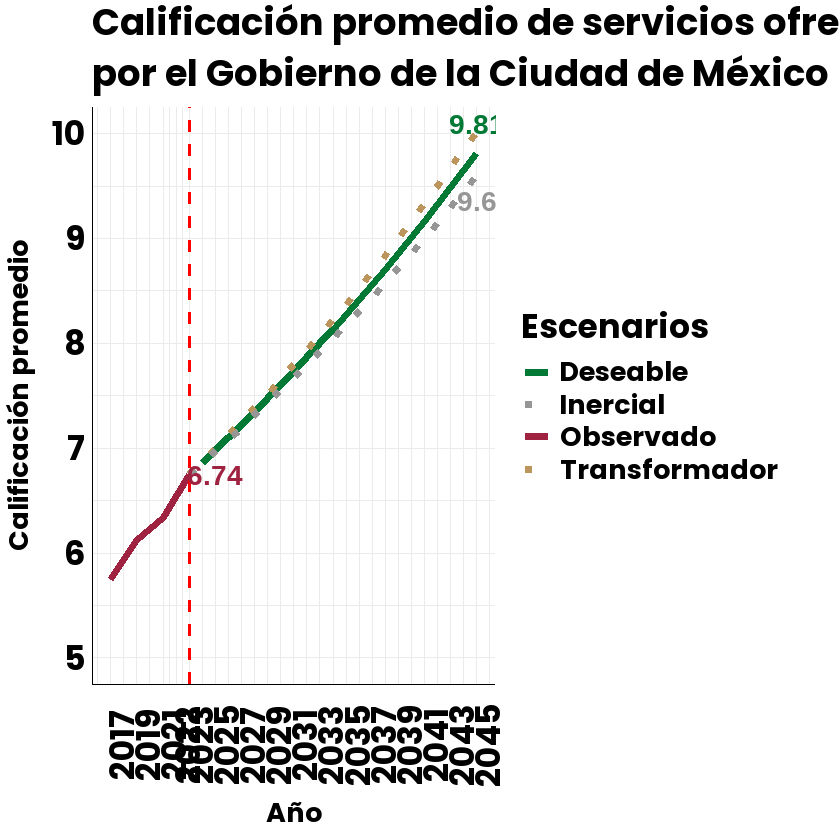

In [118]:
grafica_bonita(
  data = serie_completa_calif,
  x = "year",
  y = "estimado",
  titulo = "Calificación promedio de servicios ofrecidos 
por el Gobierno de la Ciudad de México",
    ano_base = 2023,
  mostrar_etiqueta_ano_base = TRUE,
  linea_vertical = 2023,
  anios_etiquetas = c(2045),
  desplazamiento_ano_base=c(2, 0),
  mostrar_intervalo = "ambos",
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Transformador",
  nombre_intervalo_inferior = "Inercial",
  mostrar_leyenda = TRUE,
  fuente = "pop",
  etiqueta_x = "Año",
  etiqueta_y = "Calificación promedio",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 5

)

ggsave("H:/Mi unidad/pgd/graficas/Linea 22. Gobierno para la Transformación y Finanzas Públicas para el Desarrollo/calif_gobcdmx.png",
 width = 10, height = 8.5, dpi = 185, bg = "white")